In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import data_processing as dp
# import seaborn as sns
import sqlite3
%matplotlib inline

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})

In [2]:
# open fits file and convert to csv (skip when done)
# hdul = fits.open('datasets\\asu.fit')
# data = Table(hdul[1].data)
# data.remove_columns(['Area','Sat', 'Cfl', 'OType'])
# data = data.to_pandas()
# data.to_csv('cosmos2015_dataset.csv', index=False)

In [3]:
df = pd.read_csv('datasets\\cosmos2015_dataset.csv')

In [4]:
columns = ['ra', 'dec', 'ID', 'zphot', 'redshift', 'z_lower', 'z_upper+', 'RMag', 'Class', 'log_Stellar_Mass', 'log_SFR', 'LR'] # renaming columns
df.columns = columns

In [5]:
len(np.unique(df['ID'].values)) == len(df) # no repeat galaxies

True

In [6]:
dp.check_null(df) # check for null values

ra                  0
dec                 0
ID                  0
zphot               0
redshift            0
z_lower             0
z_upper+            0
RMag                0
Class               0
log_Stellar_Mass    0
log_SFR             0
LR                  0
dtype: int64

In [7]:
df = df[df['RMag'] >= -50]
df_first_bin = df[(df['redshift'] <= 1.0) & (df['redshift'] >= 0.5)]
df_second_bin = df[(df['redshift'] <= 1.5) & (df['redshift'] > 1.0)]
df_third_bin = df[(df['redshift'] <= 2.0) & (df['redshift'] >1.5)]
df_fourth_bin = df[(df['redshift'] <= 2.5) & (df['redshift'] > 2.0)]
df_fifth_bin = df[(df['redshift'] <= 3.0) & (df['redshift'] > 2.5)]
mag_lim_df = df[(df['redshift'])<=3]

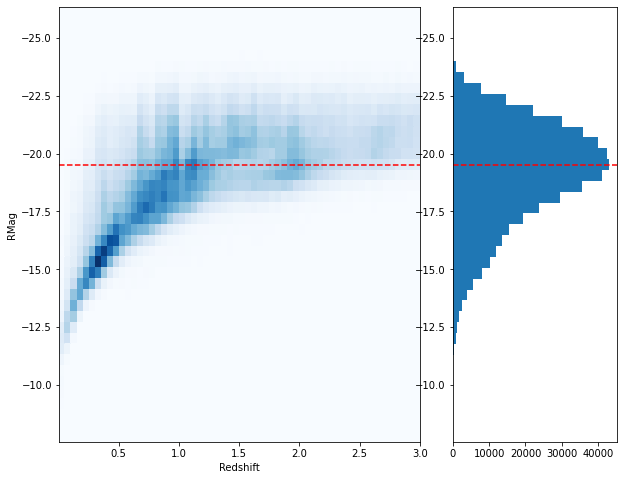

In [9]:
fig, ax = plt.subplots(figsize=(10,8), sharey=True)
main_ax = plt.subplot2grid((3,3), (0,0), rowspan=3, colspan=2, fig=fig)
hist_ax = plt.subplot2grid((3,3), (0,2), rowspan=3, fig=fig, sharey=main_ax)

h = main_ax.hist2d(mag_lim_df['redshift'], mag_lim_df['RMag'], bins=(60,40), cmap='Blues')
main_ax.axhline(-19.5, color='r', linestyle='--')
hist_ax.hist(mag_lim_df['RMag'], bins=40, orientation='horizontal')
hist_ax.axhline(-19.5, color='r', linestyle='--')

plt.gca().invert_yaxis()
main_ax.set_xlabel('Redshift')
main_ax.set_ylabel('RMag')
plt.show()

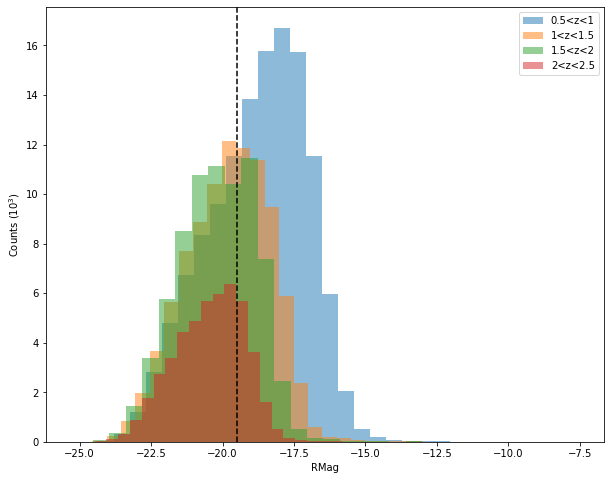

In [11]:
fig, ax = plt.subplots(figsize=(10,8))
n, bins, patches = ax.hist(df_first_bin['RMag'], bins=30, alpha=0.5, label='0.5<z<1')
ax.hist(df_second_bin['RMag'], bins=30, alpha=0.5, label='1<z<1.5')
ax.hist(df_third_bin['RMag'], bins=30, alpha=0.5, label='1.5<z<2')
ax.hist(df_fourth_bin['RMag'], bins=30, alpha=0.5, label='2<z<2.5')
ax.axvline(-19.5, color='k', linestyle='--')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(
    lambda y, pos: '%.0f' % (y * 1e-3)))
ax.set_ylabel('Counts ($10^3$)')
ax.set_xlabel('RMag')
plt.legend()
plt.show()

In [13]:
# sns.jointplot(data=mag_lim_df, x='redshift', y='RMag')
# plt.axhline(y=-19.5)
# plt.show()

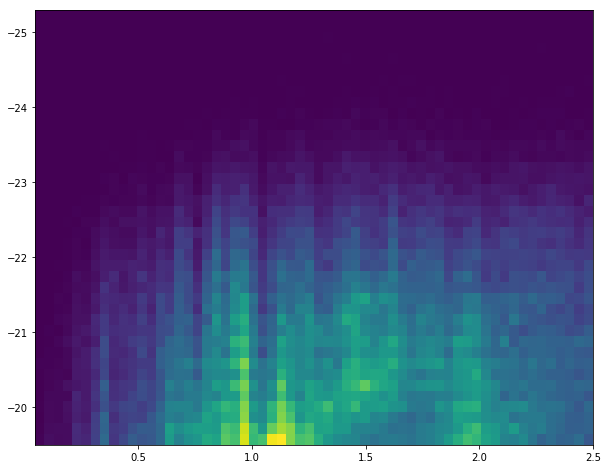

In [16]:
mag_lim_df = mag_lim_df[mag_lim_df['RMag']<=-19.5]
plt.figure(figsize=(10,8))
plt.hist2d(mag_lim_df['redshift'], mag_lim_df['RMag'], bins=(60,40))
plt.gca().invert_yaxis()
plt.show()

Text(0,0.5,'Number')

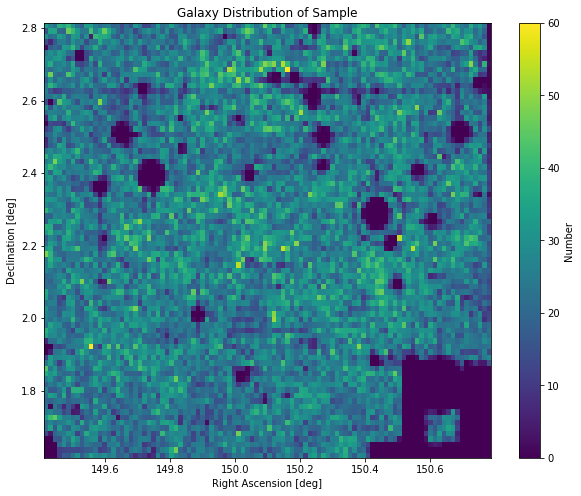

In [17]:
fig, ax = plt.subplots(figsize=(10,8))
h = ax.hist2d(mag_lim_df['ra'], mag_lim_df['dec'], bins=(100,80))
cbar = fig.colorbar(h[3], ax=ax)

ax.set_title('Galaxy Distribution of Sample')
ax.set_xlabel('Right Ascension [deg]')
ax.set_ylabel('Declination [deg]')
cbar.ax.set_ylabel('Number')

In [18]:
# remove galaxies near large masked regions, corners and edges
temp_df = mag_lim_df[(mag_lim_df['ra'] >= min(mag_lim_df['ra']) + 0.03) \
        & (mag_lim_df['ra'] <= max(mag_lim_df['ra']) - 0.03) \
        & (mag_lim_df['dec'] >= min(mag_lim_df['dec']) + 0.03) \
        & (mag_lim_df['dec'] <= max(mag_lim_df['dec']) - 0.03)]

In [19]:
df_square = mag_lim_df[(mag_lim_df['ra']>150.5) & (mag_lim_df['dec'] < 1.9)]
df_filtered = temp_df[~temp_df.isin(df_square)]
df_filtered = dp.drop_null(df_filtered)

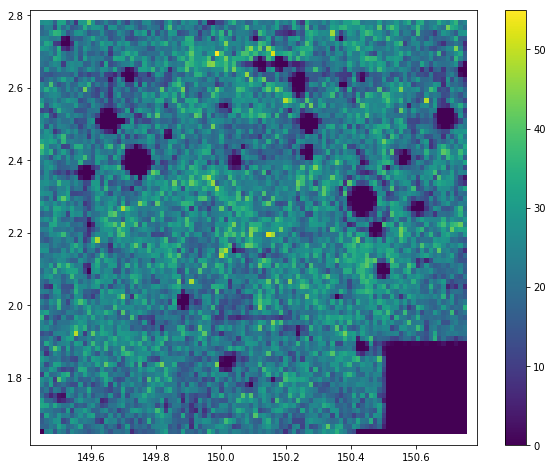

In [20]:
fig, ax = plt.subplots(figsize=(10,8))
h = ax.hist2d(df_filtered['ra'], df_filtered['dec'], bins=(100,80))
ax.set_xlim(min(mag_lim_df['ra']), max(mag_lim_df['ra']))
ax.set_ylim(min(mag_lim_df['dec']), max(mag_lim_df['dec']))
cbar = fig.colorbar(h[3], ax=ax)

In [23]:
len(mag_lim_df), len(df_filtered)

(187923, 171906)

In [22]:
dp.add_to_db(df_filtered, 'mag_lim')

Table added to SQL DB.


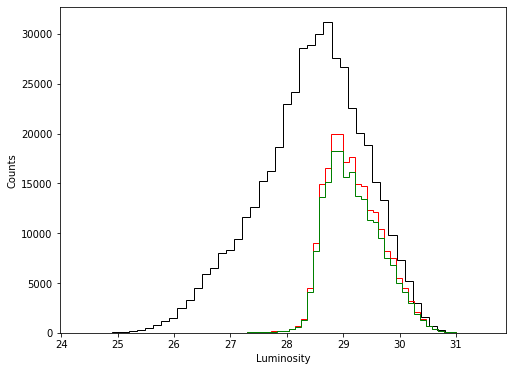

In [22]:
plt.figure(figsize=(8,6))
plt.hist(df['LR'], bins=50, histtype='step', color='k')
plt.hist(mag_lim_df['LR'], bins=50, histtype='step', color='r')
plt.hist(df_filtered['LR'], bins=50, histtype='step', color='g')
plt.xlabel('Luminosity')
plt.ylabel('Counts')
plt.show()

In [31]:
conn = sqlite3.connect('galaxy_clusters.db')
cursor = conn.cursor()
cursor.execute('''
SELECT name FROM sqlite_master WHERE type="table"
''')
print(cursor.fetchall())
conn.close()

[('deep_field',), ('cosmic_web_bcg',), ('cosmic_web_members',), ('mag_lim',)]
